In [1]:
from imports import *

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [6]:
df = acquire.get_whole_sales()

In [8]:
df = prepare.prep_sales(df)

In [30]:
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Jan,Tuesday,10.92
2013-01-01,12,26.0,211817,7,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,12018 Perrin Beitel Rd,San Antonio,TX,78217,Jan,Tuesday,218.40
2013-01-01,46,27.0,832657,7,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664,12018 Perrin Beitel Rd,San Antonio,TX,78217,Jan,Tuesday,125.55
2013-01-01,12,54.0,213643,8,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,15000 San Pedro Ave,San Antonio,TX,78232,Jan,Tuesday,453.60
2013-01-01,12,35.0,215469,9,Mueller,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,735 SW Military Dr,San Antonio,TX,78221,Jan,Tuesday,294.00


#### Data splitting

In [10]:
# split into train, validation, test
train = df.loc[:'2016-01-31']
validate = df.loc['2016-01-31':'2017-01-31']
test = df.loc['2017-01-31': ]

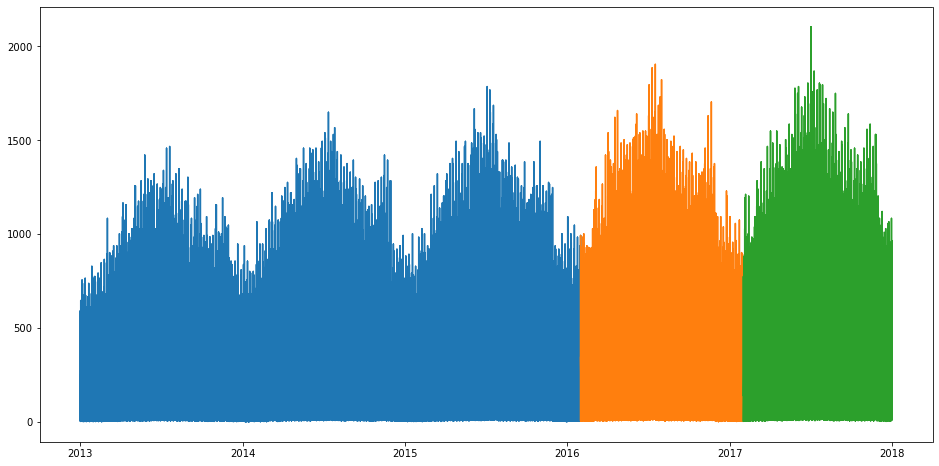

In [12]:
# Visualizing train, validate, test set
plt.figure(figsize = (16,8))
plt.plot(train.index, train.sales_total)
plt.plot(validate.index, validate.sales_total)
plt.plot(test.index, test.sales_total)

#### Functions from lesson

In [13]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [14]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [15]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [16]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forcast

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Sales Total

In [18]:
train['sales_total'][-1:][0]

325.74

In [19]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]
last_sales

325.74

In [22]:
# take the last item of quantity and assign to variable
last_quantity = train['sale_amount'][-1:][0]
last_quantity

61.0

In [24]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-31,325.74,61.0
2016-01-31,325.74,61.0
2016-01-31,325.74,61.0
2016-01-31,325.74,61.0
2016-01-31,325.74,61.0


In [25]:
yhat_df.describe()

,sales_total,quantity
count,1.835000e+05,183500.0
mean,3.257400e+02,61.0
std,5.096026e-10,0.0
min,3.257400e+02,61.0
25%,3.257400e+02,61.0
50%,3.257400e+02,61.0
75%,3.257400e+02,61.0
max,3.257400e+02,61.0


**Plot Actual vs. Predicted Values**

sales_total -- RMSE: 244


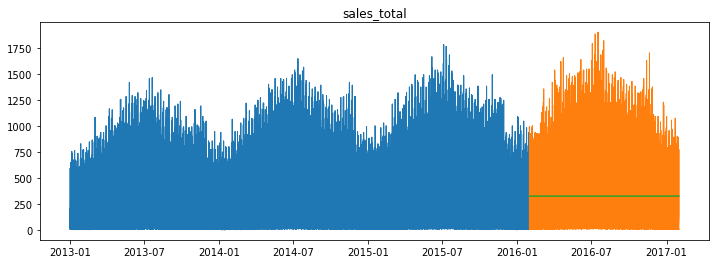

In [26]:
plot_and_eval('sales_total')

In [32]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'sales_total')

eval_df

,model_type,target_var,rmse
0,last_observed_value,sales_total,244.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [33]:
# compute simple average
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

259.91

In [36]:
avg_quantity = round(train['sale_amount'].mean(), 2)
avg_quantity

48.34

In [37]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'sales_total': [sales],
                           'quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [38]:
yhat_df = make_predictions(avg_sales, avg_quantity)

In [39]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2016-01-31,259.91,48.34
2016-01-31,259.91,48.34
2016-01-31,259.91,48.34
2016-01-31,259.91,48.34
2016-01-31,259.91,48.34


sales_total -- RMSE: 247


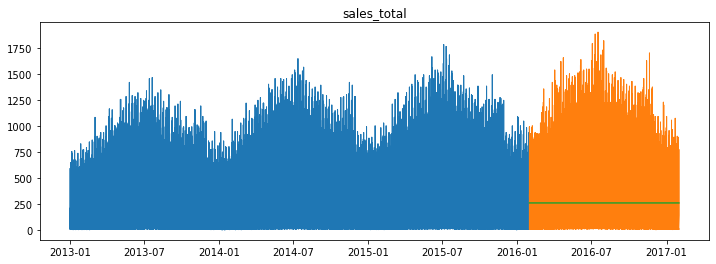

In [42]:
plot_and_eval('sales_total')

In [43]:
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'sales_total')
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales_total,244.0
1,simple_average,sales_total,247.0
